In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import random
import torch


In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
df = pd.read_csv('/content/drive/MyDrive/FinSearch/Stock_Data.csv')

In [50]:
train_data  = pd.read_csv('/content/drive/MyDrive/FinSearch/NIFTY_50.csv')
train_prices = train_data['Close'].values.reshape(-1,1)

test_data = pd.read_csv('/content/drive/MyDrive/FinSearch/NIFTY 50-13-08-2023-to-13-08-2024.csv')
test_data.columns = test_data.columns.str.strip()
test_prices = test_data['Close'].values.reshape(-1,1)

In [52]:
#Normalizing the data
scaler = MinMaxScaler()
scaled_train_prices = scaler.fit_transform(train_prices)
scaled_test_prices = scaler.fit_transform(test_prices)

#Defining the lengths
len_train_prices = len(scaled_train_prices)
len_test_prices = len(scaled_test_prices)

##LSTM Training

window_size = 3
X_train,Y_train = [],[]
X_test,Y_test= [],[]

#Creating the data for training

for i in range(len_train_prices - window_size):
  X_train.append(scaled_train_prices[i:i+window_size])
  Y_train.append(scaled_train_prices[i + window_size])

#Creating Test Data
for i in range(len_test_prices - window_size):
  X_test.append(scaled_test_prices[i:i+window_size])
  Y_test.append(scaled_test_prices[i+window_size])

#Converting the arrays into NumPy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)



In [ ]:
# Building the LSTM model
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(window_size, 1)),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
model.fit(X_train, Y_train, epochs=45, batch_size=32)

In [ ]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

In [56]:
# Inverse transform the scaled predictions to get actual prices
actual_train_predictions = scaler.inverse_transform(train_predictions)
actual_test_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
# Calculate returns and risks
test_returns = np.diff(actual_test_predictions, axis=0) / actual_test_predictions[:-1]
average_return = np.mean(test_returns)
total_return = float((actual_test_predictions[-1] - actual_test_predictions[0]) / actual_test_predictions[0])
risk = np.std(test_returns)

In [58]:
# Print return and risk metrics
print("For the model made by using LSTM, we get :- ")
print(f"Average_Return: {average_return:.4f}")
print(f"Total_Return: {total_return:.4f}")
print(f"Risk (Standard Deviation of Returns): {risk:.4f}")
print("")

For the model made by using LSTM, we get :- 
Average_Return: 0.0009
Total_Return: 0.2529
Risk (Standard Deviation of Returns): 0.0046



In [59]:
initial_investment = 10000
investment = np.float128(investment)
investment = np.float128(initial_investment)


lstm_profit = []
actions = []

#Calculating the lengths of actual predictions
len_actual_test_predictions = len(actual_test_predictions)

#The action Space :
# Buy = 1, Sell = -1 and Hold = 0

for i in range(1,len_actual_test_predictions):
      delta = ((actual_test_predictions[i] - actual_test_predictions[i-1])/actual_test_predictions[i-1])

      #Choosing the action
      if delta > 0:
        action = 1 #Buying the Stock
      elif delta ==0:
        action = 0 #Holding the Stock
      else:
        action = -1 #Selling the stock
      actions.append(action)
      investment *= (1 + delta)
      profit = investment - initial_investment
      lstm_profit.append(profit)

In [62]:
#Profits accumulated over time
accumulated_lstm_profits = []
current_profit = initial_investment

for values in lstm_profit:
  current_profit += values
  accumulated_lstm_profits.append(current_profit[0])

In [63]:
#Normalizing the Data
train_scaler = MinMaxScaler()
test_scaler = MinMaxScaler()

normalized_train_data = train_scaler.fit_transform(train_data.iloc[:,4].values.reshape(-1,1))
normalized_test_data = test_scaler.fit_transform(test_data.iloc[:,4].values.reshape(-1,1))

In [64]:
#State Function
def get_state(state_index,data):
  lookback_window = 5
  start_index = max(0,state_index - lookback_window)
  end_index = state_index + 1
  state = data[start_index : end_index].flatten()
  return state

In [65]:
#Defining the Actions
num_actions = 2
actions = {0:'Hold',1:'Buy'}

#Defining the Q-Table for storing the Q-values for each state-action pair

num_train_states = normalized_train_data.shape[0]
num_test_states = normalized_test_data.shape[0]
Q_table = torch.zeros((num_train_states,num_actions))

#Initializing the Q Table with random values
nn.init.xavier_uniform(Q_table)

<ipython-input-65-44e8ef938ae2>:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(Q_table)


tensor([[ 0.0284, -0.0022],
        [ 0.0154,  0.0091],
        [ 0.0490,  0.0124],
        ...,
        [ 0.0169, -0.0272],
        [-0.0222,  0.0251],
        [-0.0032, -0.0178]])

In [66]:
#Defining the Epsilon Greedy policy
def epsilon_greedy(state,Q_table,epsilon):
  if random.random() < epsilon:
    action = random.randint(0,num_actions - 1)
  else:
    action = torch.argmax(Q_table[state])
  return action

In [67]:
#Bellman Equation
def bellman(state,action,reward,next_state_index,Q_table):
  if next_state_index < num_train_states:
    next_state = torch.tensor([next_state_index])
    target = reward + gamma*torch.max(Q_table[next_state])
  else:
     target = reward
  Q_table[state,action] = target

In [68]:
#Training the RL model
epochs = 25
epsilon = 1.0
gamma = 0.95
replay_buffer = []
batch_size = 32
target_update_frequency = 10
target_q_table = Q_table.clone()

for i in range(epochs):
      for state in range(num_train_states - 1):
        current_state = get_state(state,normalized_train_data)
        action = epsilon_greedy(state, Q_table,epsilon)
        reward = normalized_train_data[state + 1].item()
        next_state_index = state + 1
        bellman(current_state,action,reward,next_state_index,Q_table)

        #Saving the experiences in Replay Buffer
        replay_buffer.append((current_state,action,reward,next_state_index))

        #Performing experience replay
        if len(replay_buffer) >= batch_size:
          batch = random.sample(replay_buffer,batch_size)
          for batch_current_state,batch_action,batch_reward,batch_next_state_index in batch:
            bellman(batch_current_state,batch_action,batch_reward,batch_next_state_index,Q_table)

      #Updating target Q-Table
      if i%target_update_frequency == 0:
        target_q_table = Q_table.clone()

      #Decay Epsilon
      epsilon *= 0.70

In [69]:
#Testing the model
shares  = 0
portfolio = 10000
profits = []
returns = []
risks = []

for state in range(num_test_states - 1):
  current_state = get_state(state,scaled_test_prices)
  action = torch.argmax(Q_table[state])
  if action == 1:
    shares += 1
  profit = scaler.inverse_transform([normalized_test_data[state + 1]])*shares - portfolio
  price_ratio = scaler.inverse_transform(normalized_test_data[state + 1].reshape(1,-1))/scaler.inverse_transform(normalized_test_data[state].reshape(1,-1))
  return_on_investment = (price_ratio*shares)
  risk = ((return_on_investment - portfolio)/portfolio)

  profits.append(profit)
  returns.append(price_ratio)
  risks.append(risk)

In [70]:
#Flattening the profits list
flat_profits = [item for sublist in profits for item in sublist]

In [ ]:
average_return = float(sum(returns)/len(returns))
total_profits = float(sum(profits))
total_risk = float(sum([abs(risk) for risk in risks]))
average_risk = float(total_risk/len(risks))

In [72]:
#Printing the required values
print("The values that are calculated are as follows : ")
print(f"Average Return : {average_return:.4f}")
print(f"Total Profits : {total_profits:.4f}")
print(f"Total Risk : {total_risk:.4f}")
print(f"Average Risk : {average_risk:.4f}")

The values that are calculated are as follows : 
Average Return : 1.0009
Total Profits : 389179625.6500
Total Risk : 245.2682
Average Risk : 0.9930


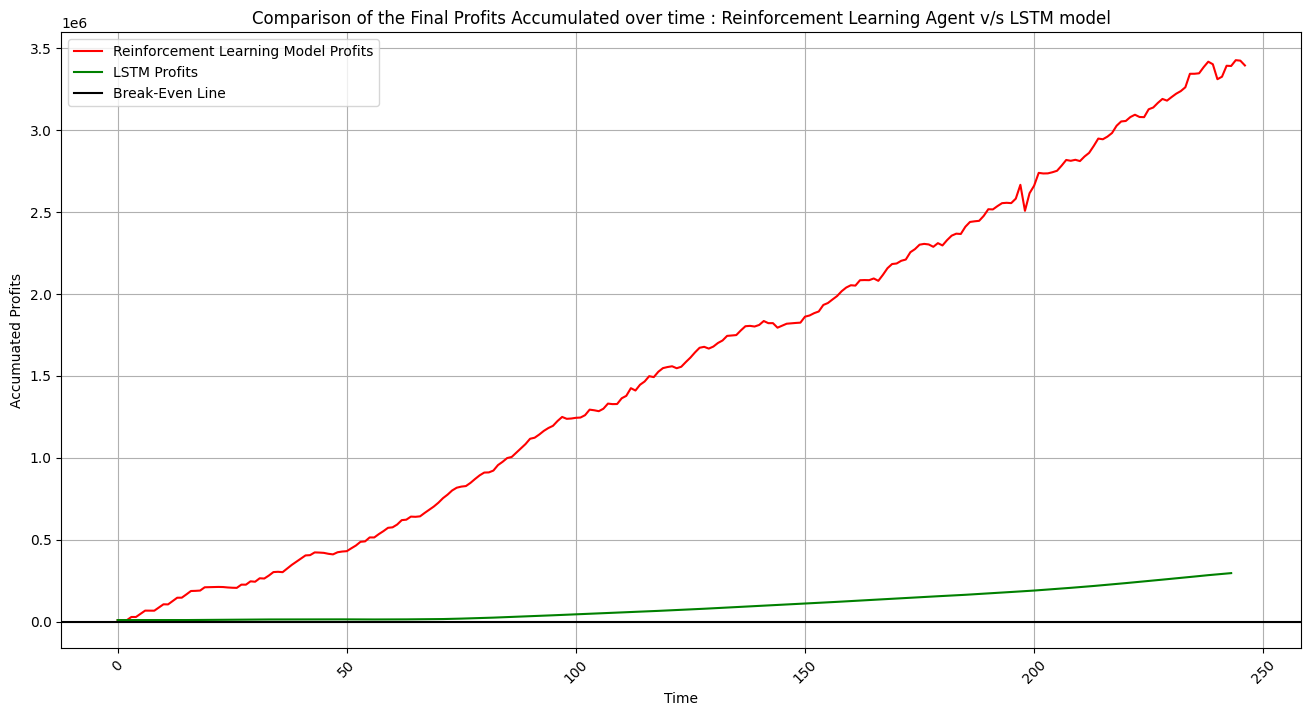

In [73]:
plt.figure(figsize=(16,8))
plt.plot(flat_profits,label = 'Reinforcement Learning Model Profits',color = 'red')
plt.plot(accumulated_lstm_profits,label = 'LSTM Profits',color = 'green')
plt.axhline(y=0, color = 'black', linestyle = '-',label = 'Break-Even Line')
plt.xlabel('Time')
plt.ylabel('Accumuated Profits')
plt.title('Comparison of the Final Profits Accumulated over time : Reinforcement Learning Agent v/s LSTM model')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()